In [2]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import shap
import statsmodels.api as sm

conn = sqlite3.connect('../simulations.db')
c = conn.cursor()

In [3]:
query = "SELECT mu, sigma, kappa, theta, rho, v0, GC_cum_KS_p FROM simulations where feller_condition = 1 and max_number_of_same_prices = 1"
df = pd.read_sql_query(query, conn)

X = df[['mu', 'sigma', 'kappa', 'theta', 'rho', 'v0']]
y = (df['GC_cum_KS_p'] > 0.05).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Random Guess Accuracy: ", y_test.mean())

Random Guess Accuracy:  0.6098426309554592


In [7]:

# Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)
y_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC AUC:", roc_auc)
cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Accuracy: 0.7953120020204815
Confusion Matrix:
[[46046 18836]
 [15203 86212]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73     64882
           1       0.82      0.85      0.84    101415

    accuracy                           0.80    166297
   macro avg       0.79      0.78      0.78    166297
weighted avg       0.79      0.80      0.79    166297

ROC AUC: 0.8487191321862262
Cross-Validation Scores: [0.67523166 0.69829281 0.78958129 0.88343145 0.88859022]
Mean CV Accuracy: 0.7870254888425223


Varianzanteile der Komponenten: [0.55298558 0.19243986]


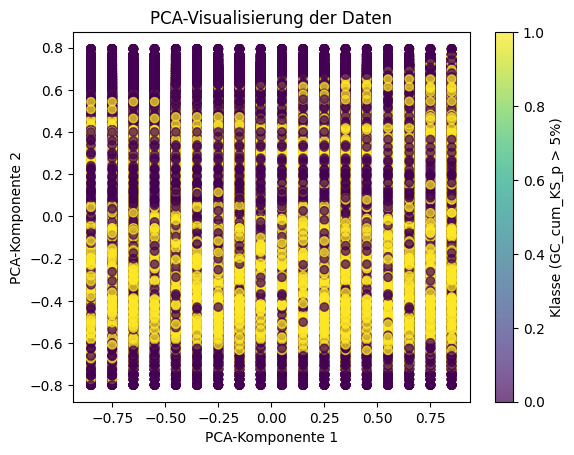

In [8]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print("Varianzanteile der Komponenten:", pca.explained_variance_ratio_)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.xlabel("PCA-Komponente 1")
plt.ylabel("PCA-Komponente 2")
plt.title("PCA-Visualisierung der Daten")
plt.colorbar(scatter, label="Klasse (GC_cum_KS_p > 5%)")
plt.show()

In [ ]:
# SVM
model = SVC(kernel='rbf', C=1.0, gamma='scale')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [8]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9158613805420422
Confusion Matrix:
[[56560  8322]
 [ 5670 95745]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     64882
           1       0.92      0.94      0.93    101415

    accuracy                           0.92    166297
   macro avg       0.91      0.91      0.91    166297
weighted avg       0.92      0.92      0.92    166297



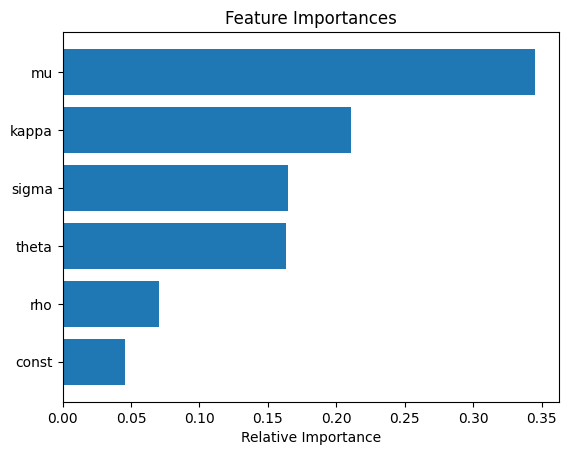

In [9]:
importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig('feature_importances.png')
plt.show()

In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

In [6]:
X = sm.add_constant(X)
model = sm.Logit(y, X)
result = model.fit()
print(result.summary())
odds_ratios = np.exp(abs(result.params))
print(odds_ratios)

Optimization terminated successfully.
         Current function value: 0.474383
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            GC_cum_KS_p   No. Observations:               831484
Model:                          Logit   Df Residuals:                   831477
Method:                           MLE   Df Model:                            6
Date:                Tue, 11 Mar 2025   Pseudo R-squ.:                  0.2902
Time:                        14:03:41   Log-Likelihood:            -3.9444e+05
converged:                       True   LL-Null:                   -5.5570e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8708      0.010    -84.332      0.000      -0.891      -0.851
mu            -1.2841      0.